In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.ar_truncated_normal_observation import ARTruncatedNormalObservation
from project_ssms.coupled_transformations.grid_transformation import GridTransformation
from project_ssms.single_transformations import single_direction_transformation
from project_ssms.feature_funcs import feature_direction_vec
from project_ssms.momentum_utils import filter_traj_by_speed, get_momentum_in_batch
from project_ssms.utils import k_step_prediction_for_grid_model
from project_ssms.plot_utils import plot_z, plot_2_mice, plot_4_traces

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

import joblib

# data

In [3]:
trajs_all = joblib.load("trajs_all")
trajs = trajs_all[36000*0:36000*1]
f_trajs = filter_traj_by_speed(trajs, q1=0.9, q2=0.9)

In [4]:
arena_xmin = 10
arena_xmax = 320
arena_ymin = -10
arena_ymax = 390

In [5]:
# make 3 by 3 grid world
x_grid_gap = (arena_xmax - arena_xmin) / 3
y_grid_gap = (arena_ymax - arena_ymin) / 3

x_grids = [arena_xmin + i * x_grid_gap for i in range(4)]
y_grids = [arena_ymin + i * y_grid_gap for i in range(4)]

In [6]:
bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])

In [7]:
CORNERS = torch.tensor([[10, -10], [10, 390], [320, -10], [320, 390]], dtype=torch.float64)

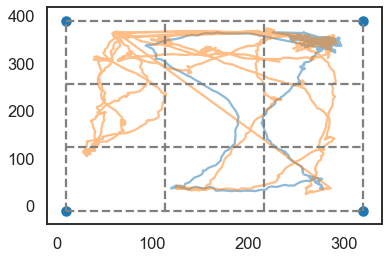

In [8]:
plot_2_mice(trajs[:3600], alpha=0.5)
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')


In [9]:
data = torch.tensor(trajs[:3600], dtype=torch.float64)

# model

In [10]:
torch.manual_seed(0)
np.random.seed(0)

D = 4
K = 2
M = 0

Df = 4

f_corner_vec_func = lambda s: feature_direction_vec(s, CORNERS)

bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])


tran = GridTransformation(K=K, D=D, x_grids=x_grids, y_grids=y_grids, single_transformation="direction",
                          Df=Df, feature_vec_func=f_corner_vec_func, acc_factor=10)

# compute memories
masks_a, masks_b = tran.get_masks(data[:-1])
feature_vecs_a = f_corner_vec_func(data[:-1, 0:2])
feature_vecs_b = f_corner_vec_func(data[:-1, 2:4])

m_kwargs_a = dict(feature_vecs=feature_vecs_a)
m_kwargs_b = dict(feature_vecs=feature_vecs_b)

obs = ARTruncatedNormalObservation(K=K, D=D, M=M, lags=1, bounds=bounds, transformation=tran)

# model
model = HMM(K=K, D=D, M=M, observation=obs)


In [11]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [12]:
log_prob = model.log_likelihood(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

In [13]:
log_prob

tensor(-213110.2564, dtype=torch.float64, grad_fn=<AddBackward0>)

# training

In [14]:
##################### training ############################

num_iters = 5000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 4990 loss 24794.84: 100%|██████████| 5000/5000 [05:21<00:00, 15.48it/s]


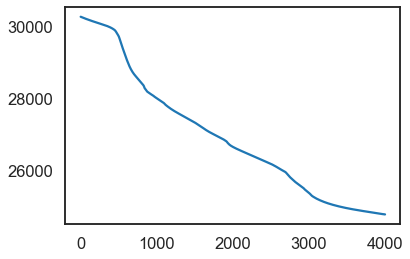

In [15]:
plt.plot(losses[1000:])

In [16]:
print("inferiring most likely states...")
z = model.most_likely_states(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

inferiring most likely states...


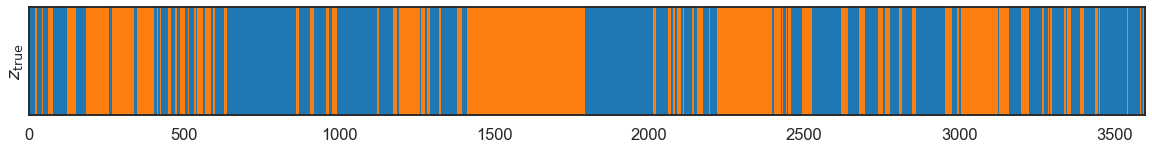

In [17]:
plot_z(z)

In [18]:
print("0 step prediction")
x_predict = k_step_prediction_for_grid_model(model, z, data, memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

0 step prediction


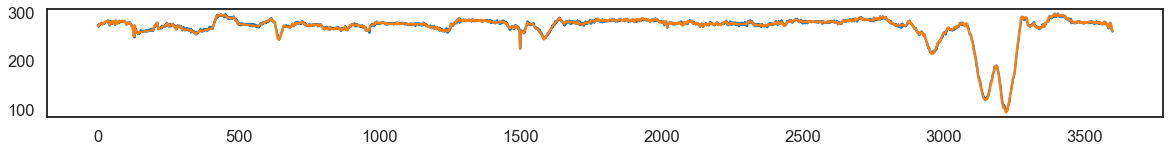

In [19]:
plt.figure(figsize=(20,2))
plt.plot(x_predict[:,0])
plt.plot(data[:,0].numpy())

In [20]:
np.average(np.abs(x_predict-data.numpy()), axis=0)

array([1.37225067, 1.39535036, 2.54868194, 2.14115126])

# sample

In [21]:
sample_z, sample_x = model.sample(3600)

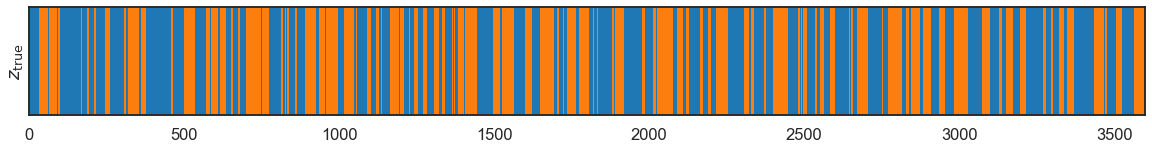

In [22]:
plot_z(sample_z)

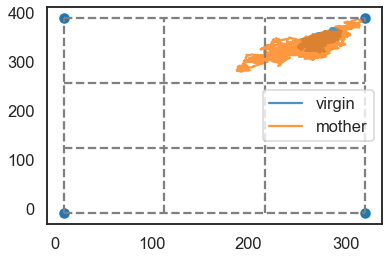

In [23]:
plot_2_mice(sample_x)
plt.legend()
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

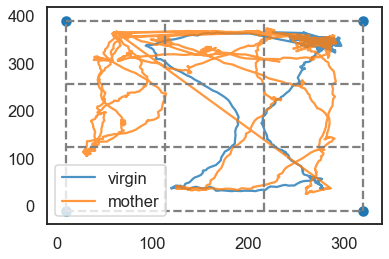

In [24]:
plot_2_mice(data.numpy())
plt.legend()
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

In [28]:
sample_z2, sample_x2 = model.sample(10000, transformation=True)

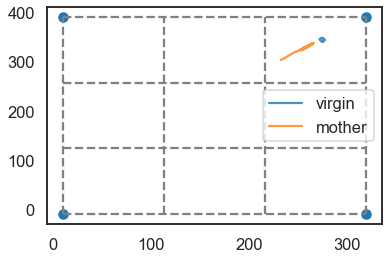

In [29]:
plot_2_mice(sample_x2)
plt.legend()
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')